In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from braindecode.models import EEGNet
import copy
import random
import pandas as pd
from tqdm import notebook
import tqdm
from pathlib import Path
import numpy as np
import scipy


torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA RTX 3000 Ada Generation Laptop GPU'

In [3]:
!nvidia-smi

Fri Jan 16 16:28:46 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 3000 Ada Gene...    Off |   00000000:01:00.0 Off |                  Off |
| N/A   42C    P8              2W /   35W |      13MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Utilities

In [4]:
from cross_subject_utils import (
    plot_learning_curves,
    evaluate,
    get_windows,
    load_data_from_users,
    get_windows,
)

In [5]:
from cca import CCA_otimizacao, matriz_referencia

In [6]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100,
    device=0,
    save_path="best_model.pth",
):
    best_val_accuracy = -float("inf")
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in tqdm.notebook.tqdm(range(num_epochs)):
        # Training Phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # eval train
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)

        # eval validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # val accuracy
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Save if best vall acc
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            # print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")

        print(
            f"Epoch {epoch + 1}/{num_epochs}: "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    model.load_state_dict(best_model)
    return model

# Cross Subject

In [11]:
freq_phase_path = (
    "/home/mateuschinelatto/Experiments/data/benchmark/Freq_Phase.mat"
)
freq_phase = scipy.io.loadmat(freq_phase_path)
frequencias = np.round(freq_phase["freqs"], 2).ravel()
fases = freq_phase["phases"]

# Parâmetros do pré-processamento
sample_rate = 250
filter_order = 10
freq_cut_high = 70
freq_cut_low = 6
delay = 160

# Parâmetros do CCA
num_harmonica = 5
inform_fase = 0

# Parâmetros de janelas e sessões
tamanho_da_janela_seg = 4
tamanho_da_janela = int(np.ceil(tamanho_da_janela_seg * sample_rate))

occipital_electrodes = np.array([47, 53, 54, 55, 56, 57, 60, 61, 62])
frequencias_desejadas = frequencias[:8]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

# Usuários
# users = list(range(1, 36))  # Usuários de 1 a 35
users = list(range(1, 11))  # Usuários de 1 a 10

epochs = 1000
exp_dir = Path(
    f"CCA_eegnet/{len(users)}_users_{len(frequencias_desejadas)}_freqs_{tamanho_da_janela_seg}_s/"
)

In [12]:
print("Usuários de interesse:", users)
print(f"Frequencies used: {frequencias_desejadas}")
print(f"Frequencies indices: {indices}")

Usuários de interesse: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequencies used: [ 8.  9. 10. 11. 12. 13. 14. 15.]
Frequencies indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]


In [9]:
all_data = load_data_from_users(
    dataset_path="/home/mateuschinelatto/Experiments/data/benchmark/",
    users=users,
    visual_delay=delay,
    filter_bandpass=True,
    sample_rate=sample_rate,
    freq_cut_low=freq_cut_low,
    freq_cut_high=freq_cut_high,
    filter_order=filter_order,
)

Carregando dados dos usuários:   0%|          | 0/10 [00:00<?, ?it/s]

# Hard code

Processando Usuário 1
Train Users: [2, 3, 4, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shap

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0940, Train Accuracy: 0.1362, Val Loss: 2.0818, Val Accuracy: 0.1077
Epoch 2/1000: Train Loss: 2.0849, Train Accuracy: 0.1281, Val Loss: 2.0817, Val Accuracy: 0.0923
Epoch 3/1000: Train Loss: 2.0686, Train Accuracy: 0.1744, Val Loss: 2.0815, Val Accuracy: 0.0615
Epoch 4/1000: Train Loss: 2.0814, Train Accuracy: 0.1553, Val Loss: 2.0814, Val Accuracy: 0.0462
Epoch 5/1000: Train Loss: 2.0597, Train Accuracy: 0.1553, Val Loss: 2.0813, Val Accuracy: 0.0462
Epoch 6/1000: Train Loss: 2.0788, Train Accuracy: 0.1580, Val Loss: 2.0811, Val Accuracy: 0.0615
Epoch 7/1000: Train Loss: 2.0549, Train Accuracy: 0.1635, Val Loss: 2.0810, Val Accuracy: 0.0615
Epoch 8/1000: Train Loss: 2.0471, Train Accuracy: 0.1853, Val Loss: 2.0809, Val Accuracy: 0.0615
Epoch 9/1000: Train Loss: 2.0589, Train Accuracy: 0.1689, Val Loss: 2.0809, Val Accuracy: 0.0615
Epoch 10/1000: Train Loss: 2.0443, Train Accuracy: 0.1880, Val Loss: 2.0809, Val Accuracy: 0.0615
Epoch 11/1000: Train Loss: 2.

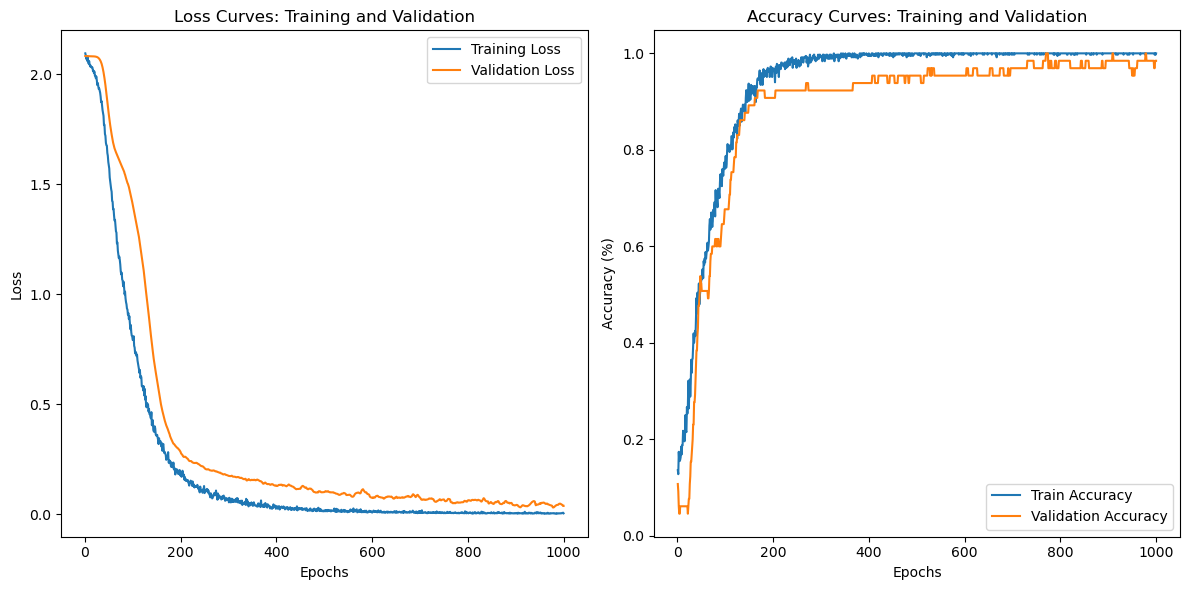

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000


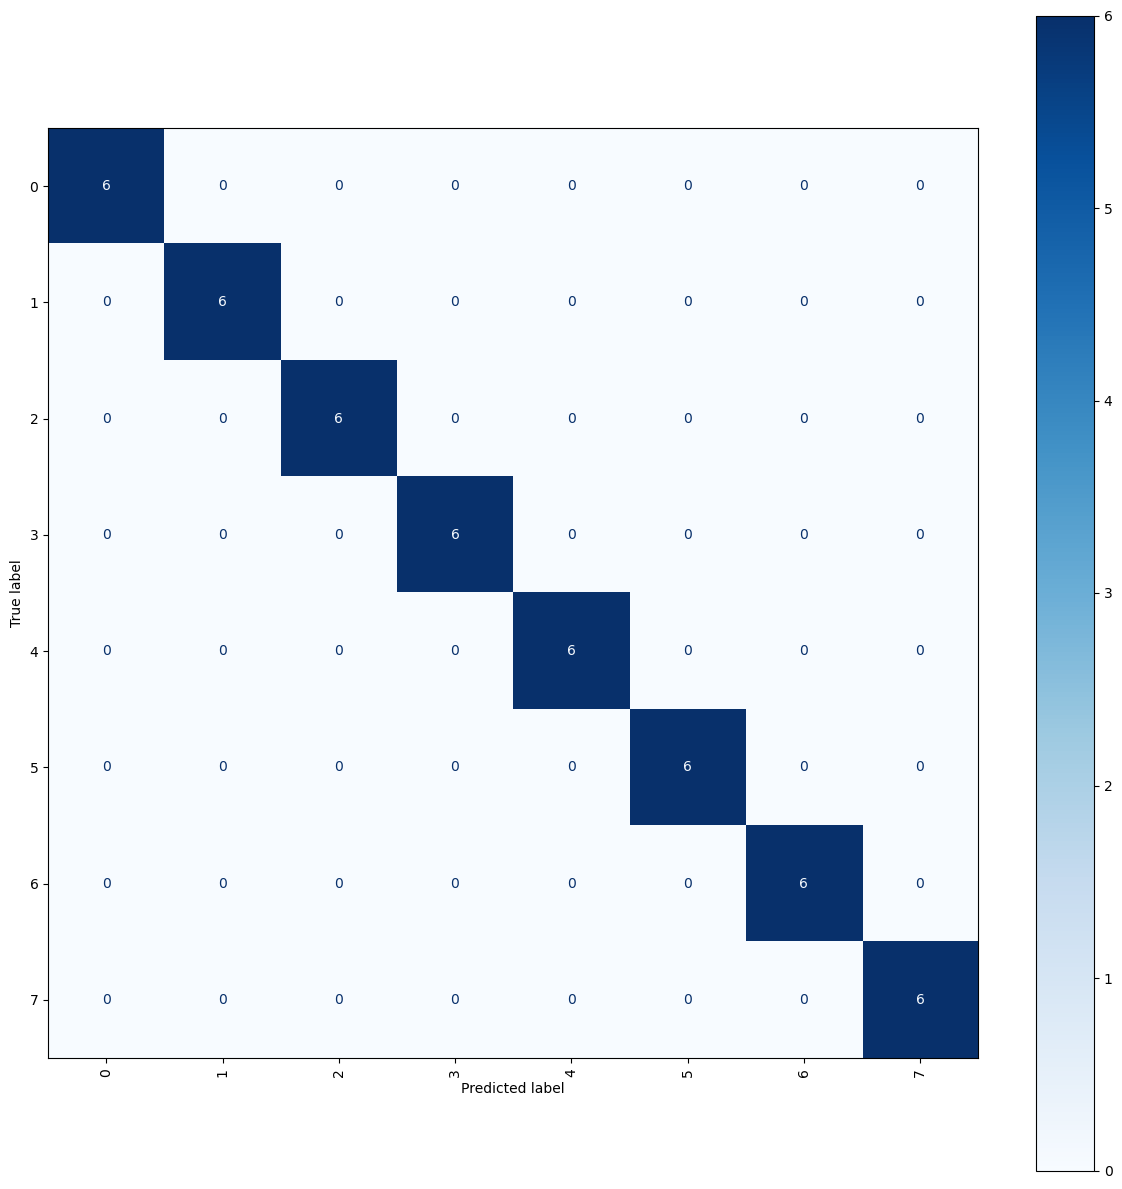

Test User 1 Finished: Accuracy=1.0000, Recall=1.0000, F1=1.0000
--------------------------------------------------
Processando Usuário 2
Train Users: [1, 3, 4, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0949, Train Accuracy: 0.1253, Val Loss: 2.0806, Val Accuracy: 0.1231
Epoch 2/1000: Train Loss: 2.0867, Train Accuracy: 0.1253, Val Loss: 2.0805, Val Accuracy: 0.1538
Epoch 3/1000: Train Loss: 2.0874, Train Accuracy: 0.1253, Val Loss: 2.0805, Val Accuracy: 0.1692
Epoch 4/1000: Train Loss: 2.0880, Train Accuracy: 0.1063, Val Loss: 2.0805, Val Accuracy: 0.1846
Epoch 5/1000: Train Loss: 2.0710, Train Accuracy: 0.1471, Val Loss: 2.0805, Val Accuracy: 0.1846
Epoch 6/1000: Train Loss: 2.0716, Train Accuracy: 0.1308, Val Loss: 2.0804, Val Accuracy: 0.1692
Epoch 7/1000: Train Loss: 2.0616, Train Accuracy: 0.1798, Val Loss: 2.0803, Val Accuracy: 0.1692
Epoch 8/1000: Train Loss: 2.0640, Train Accuracy: 0.1826, Val Loss: 2.0803, Val Accuracy: 0.1846
Epoch 9/1000: Train Loss: 2.0577, Train Accuracy: 0.1798, Val Loss: 2.0802, Val Accuracy: 0.1692
Epoch 10/1000: Train Loss: 2.0552, Train Accuracy: 0.1798, Val Loss: 2.0801, Val Accuracy: 0.1692
Epoch 11/1000: Train Loss: 2.

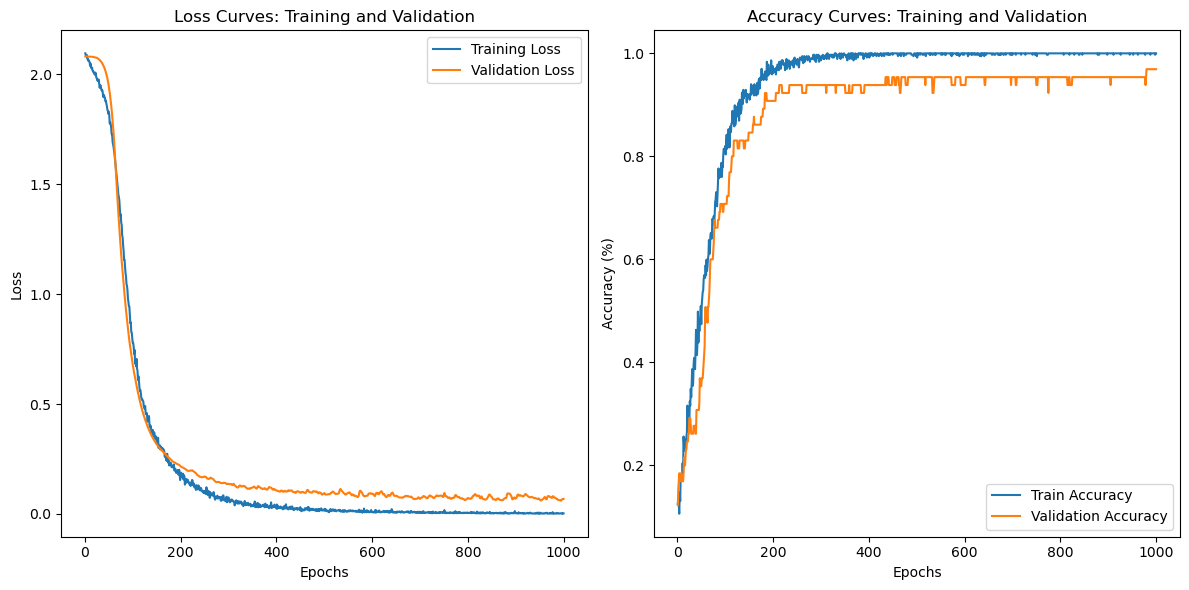

Test set Accuracy: 0.9583
Recall: 0.9583
F1 Score: 0.9580


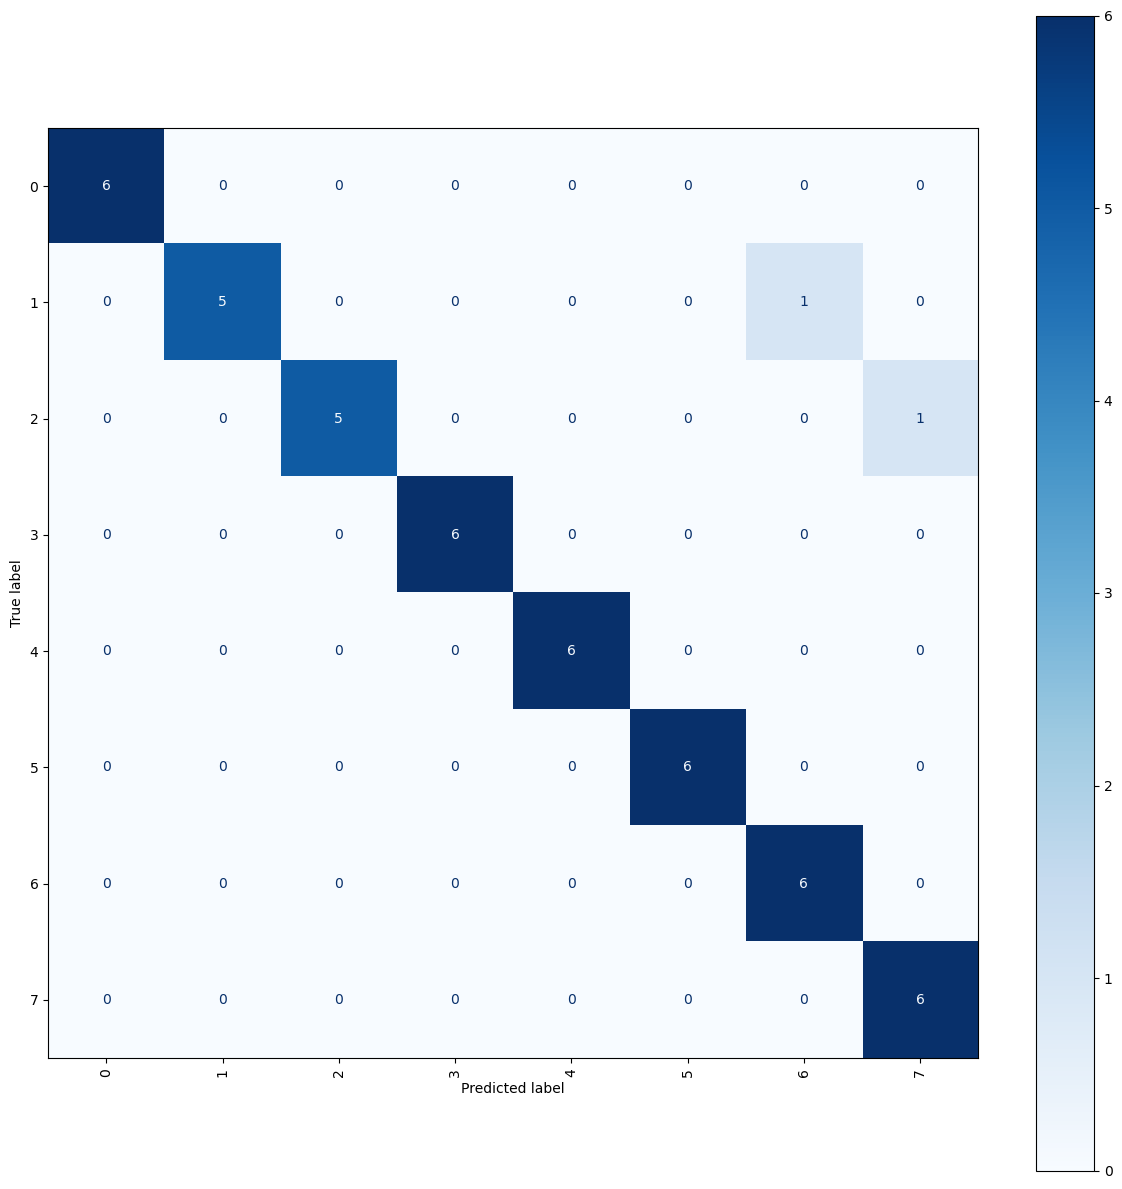

Test User 2 Finished: Accuracy=0.9583, Recall=0.9583, F1=0.9580
--------------------------------------------------
Processando Usuário 3
Train Users: [1, 2, 4, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0964, Train Accuracy: 0.1199, Val Loss: 2.0794, Val Accuracy: 0.2000
Epoch 2/1000: Train Loss: 2.0880, Train Accuracy: 0.1281, Val Loss: 2.0795, Val Accuracy: 0.2308
Epoch 3/1000: Train Loss: 2.0853, Train Accuracy: 0.1308, Val Loss: 2.0797, Val Accuracy: 0.2000
Epoch 4/1000: Train Loss: 2.0788, Train Accuracy: 0.1444, Val Loss: 2.0799, Val Accuracy: 0.2154
Epoch 5/1000: Train Loss: 2.0716, Train Accuracy: 0.1471, Val Loss: 2.0800, Val Accuracy: 0.1846
Epoch 6/1000: Train Loss: 2.0771, Train Accuracy: 0.1526, Val Loss: 2.0802, Val Accuracy: 0.2154
Epoch 7/1000: Train Loss: 2.0637, Train Accuracy: 0.1853, Val Loss: 2.0803, Val Accuracy: 0.2000
Epoch 8/1000: Train Loss: 2.0681, Train Accuracy: 0.1526, Val Loss: 2.0805, Val Accuracy: 0.2154
Epoch 9/1000: Train Loss: 2.0514, Train Accuracy: 0.1717, Val Loss: 2.0805, Val Accuracy: 0.2154
Epoch 10/1000: Train Loss: 2.0583, Train Accuracy: 0.1880, Val Loss: 2.0807, Val Accuracy: 0.2154
Epoch 11/1000: Train Loss: 2.

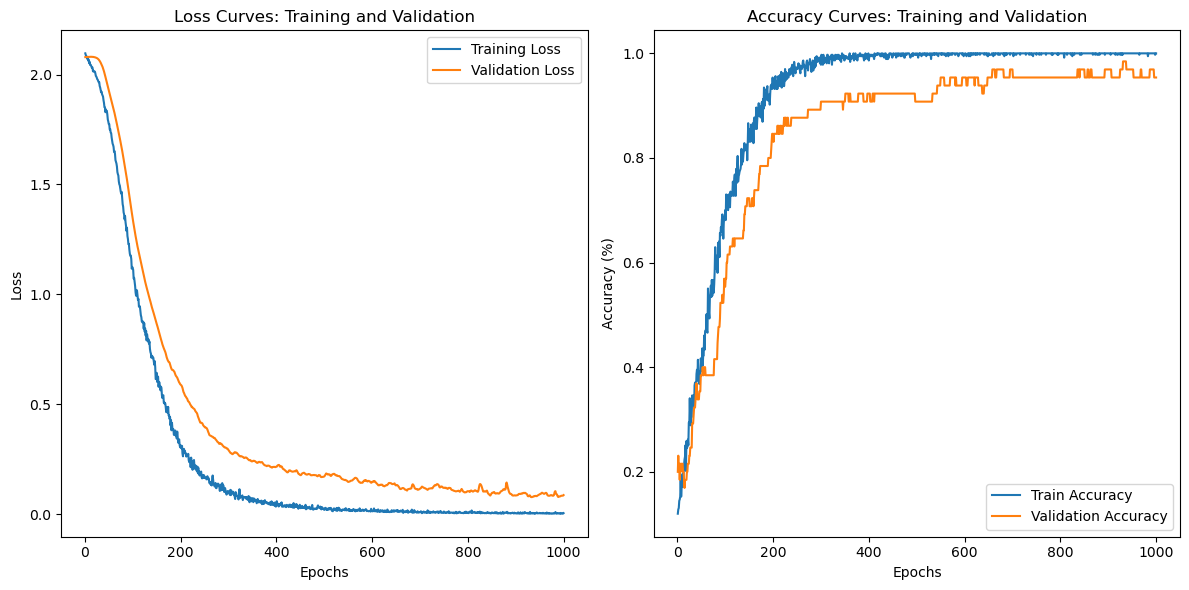

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000


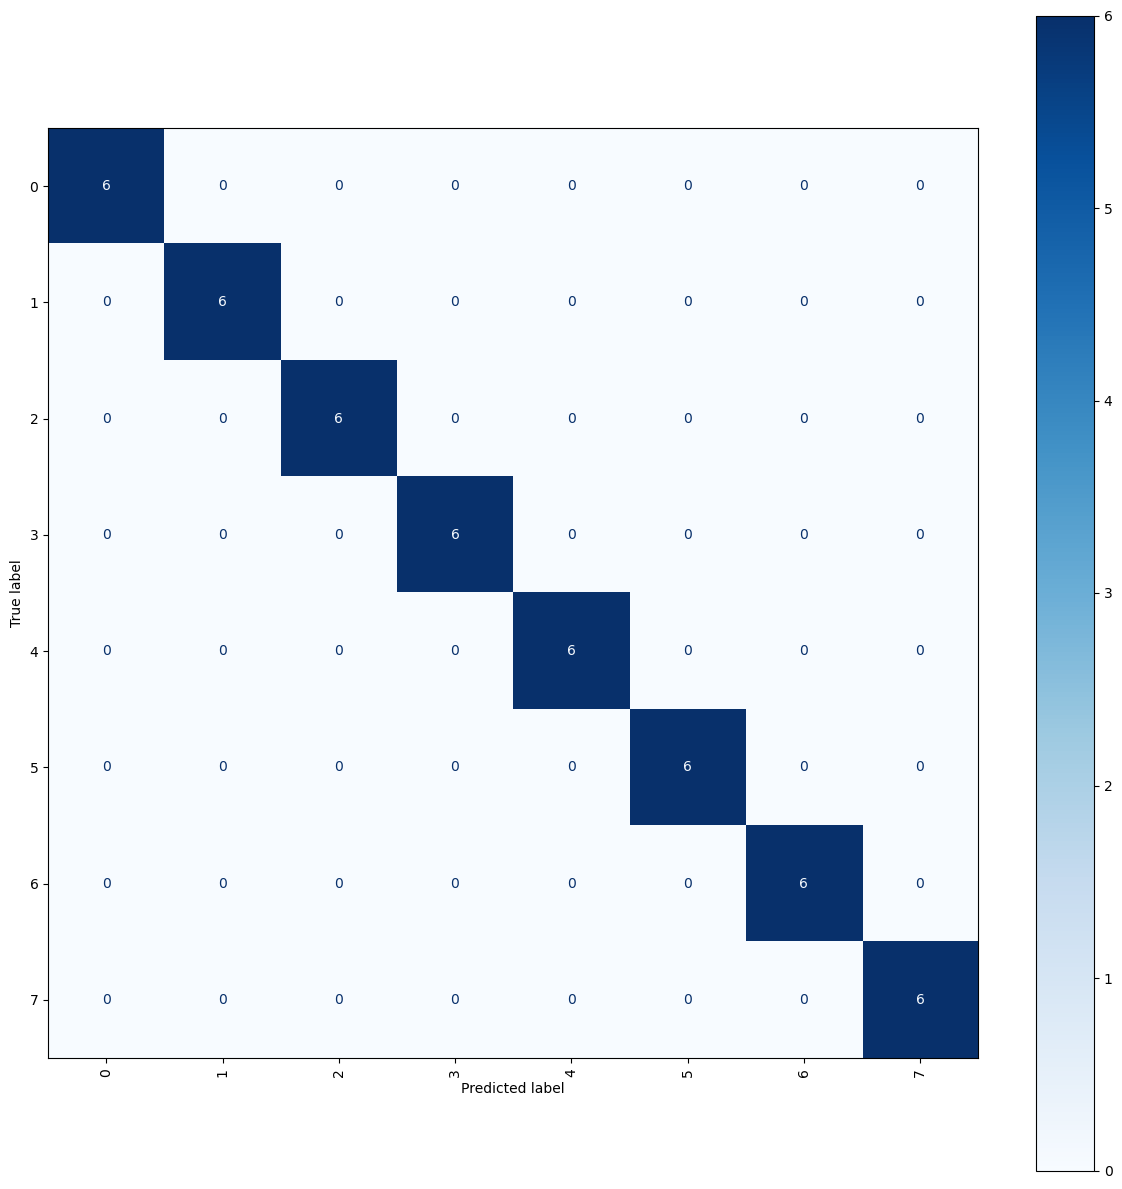

Test User 3 Finished: Accuracy=1.0000, Recall=1.0000, F1=1.0000
--------------------------------------------------
Processando Usuário 4
Train Users: [1, 2, 3, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0927, Train Accuracy: 0.1090, Val Loss: 2.0800, Val Accuracy: 0.1231
Epoch 2/1000: Train Loss: 2.0773, Train Accuracy: 0.1390, Val Loss: 2.0796, Val Accuracy: 0.1077
Epoch 3/1000: Train Loss: 2.0849, Train Accuracy: 0.1308, Val Loss: 2.0793, Val Accuracy: 0.0923
Epoch 4/1000: Train Loss: 2.0761, Train Accuracy: 0.1471, Val Loss: 2.0790, Val Accuracy: 0.0923
Epoch 5/1000: Train Loss: 2.0562, Train Accuracy: 0.1907, Val Loss: 2.0787, Val Accuracy: 0.0769
Epoch 6/1000: Train Loss: 2.0707, Train Accuracy: 0.1526, Val Loss: 2.0784, Val Accuracy: 0.0615
Epoch 7/1000: Train Loss: 2.0445, Train Accuracy: 0.2207, Val Loss: 2.0780, Val Accuracy: 0.0615
Epoch 8/1000: Train Loss: 2.0436, Train Accuracy: 0.1689, Val Loss: 2.0776, Val Accuracy: 0.0769
Epoch 9/1000: Train Loss: 2.0417, Train Accuracy: 0.1989, Val Loss: 2.0772, Val Accuracy: 0.0923
Epoch 10/1000: Train Loss: 2.0400, Train Accuracy: 0.2207, Val Loss: 2.0767, Val Accuracy: 0.0923
Epoch 11/1000: Train Loss: 2.

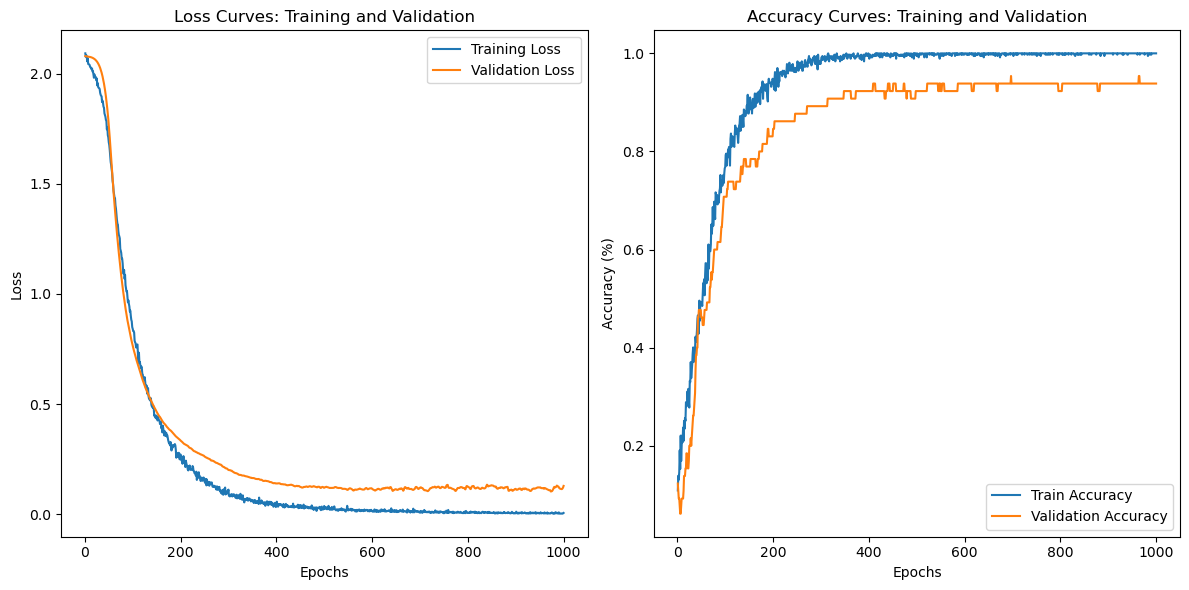

Test set Accuracy: 0.9583
Recall: 0.9583
F1 Score: 0.9594


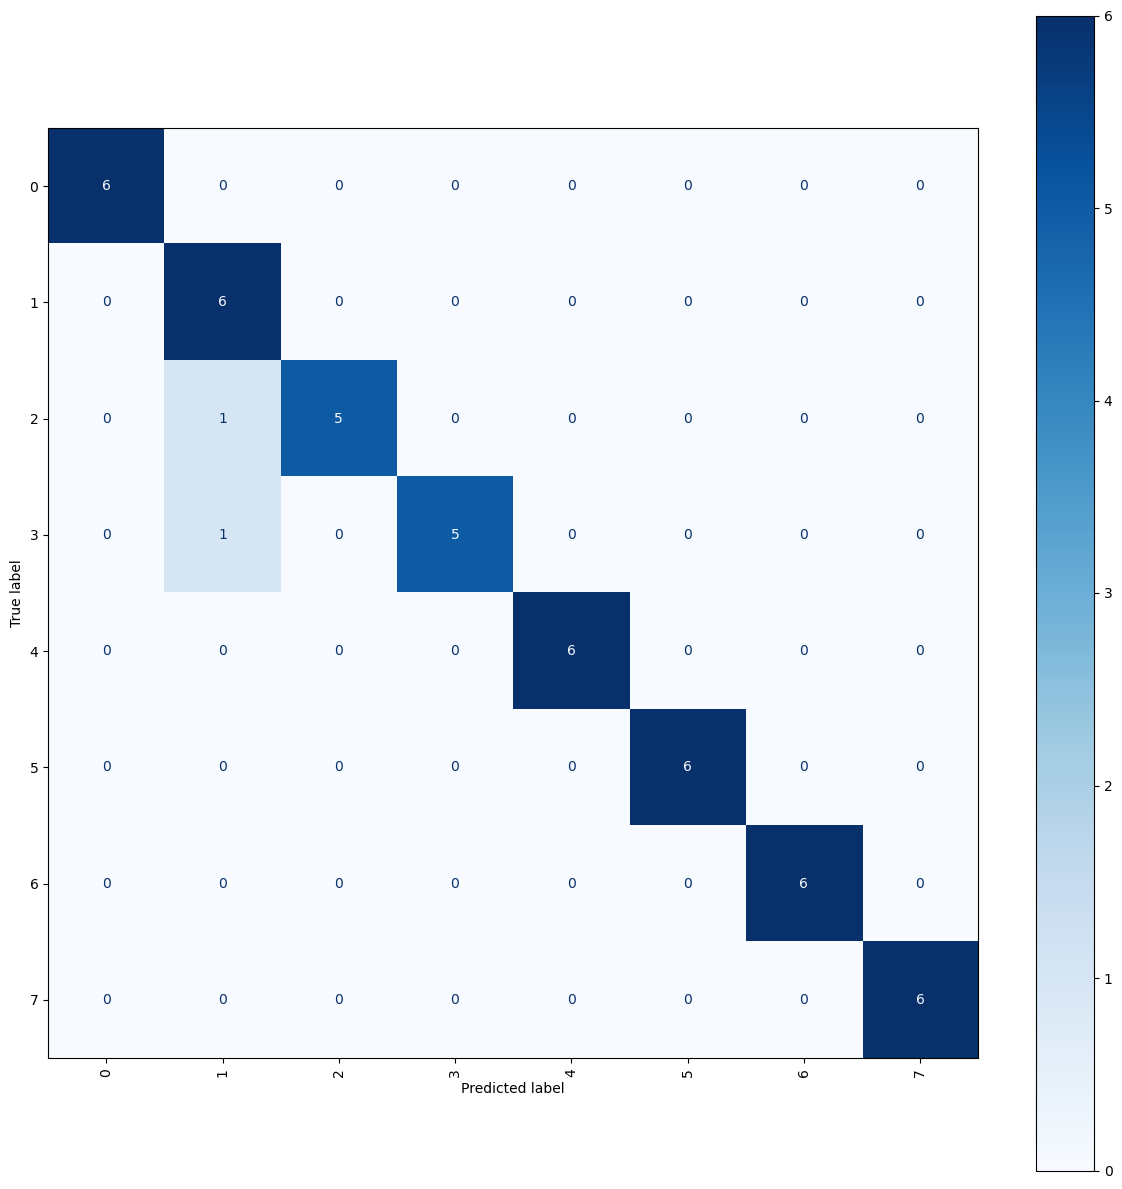

Test User 4 Finished: Accuracy=0.9583, Recall=0.9583, F1=0.9594
--------------------------------------------------
Processando Usuário 5
Train Users: [1, 2, 3, 4, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0920, Train Accuracy: 0.1117, Val Loss: 2.0780, Val Accuracy: 0.1538
Epoch 2/1000: Train Loss: 2.0916, Train Accuracy: 0.1471, Val Loss: 2.0775, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.0813, Train Accuracy: 0.1090, Val Loss: 2.0769, Val Accuracy: 0.1538
Epoch 4/1000: Train Loss: 2.0838, Train Accuracy: 0.1281, Val Loss: 2.0764, Val Accuracy: 0.1077
Epoch 5/1000: Train Loss: 2.0718, Train Accuracy: 0.1526, Val Loss: 2.0758, Val Accuracy: 0.0923
Epoch 6/1000: Train Loss: 2.0605, Train Accuracy: 0.1662, Val Loss: 2.0751, Val Accuracy: 0.0923
Epoch 7/1000: Train Loss: 2.0666, Train Accuracy: 0.1444, Val Loss: 2.0745, Val Accuracy: 0.1231
Epoch 8/1000: Train Loss: 2.0578, Train Accuracy: 0.1553, Val Loss: 2.0738, Val Accuracy: 0.1077
Epoch 9/1000: Train Loss: 2.0564, Train Accuracy: 0.1826, Val Loss: 2.0730, Val Accuracy: 0.1231
Epoch 10/1000: Train Loss: 2.0506, Train Accuracy: 0.1744, Val Loss: 2.0721, Val Accuracy: 0.1231
Epoch 11/1000: Train Loss: 2.

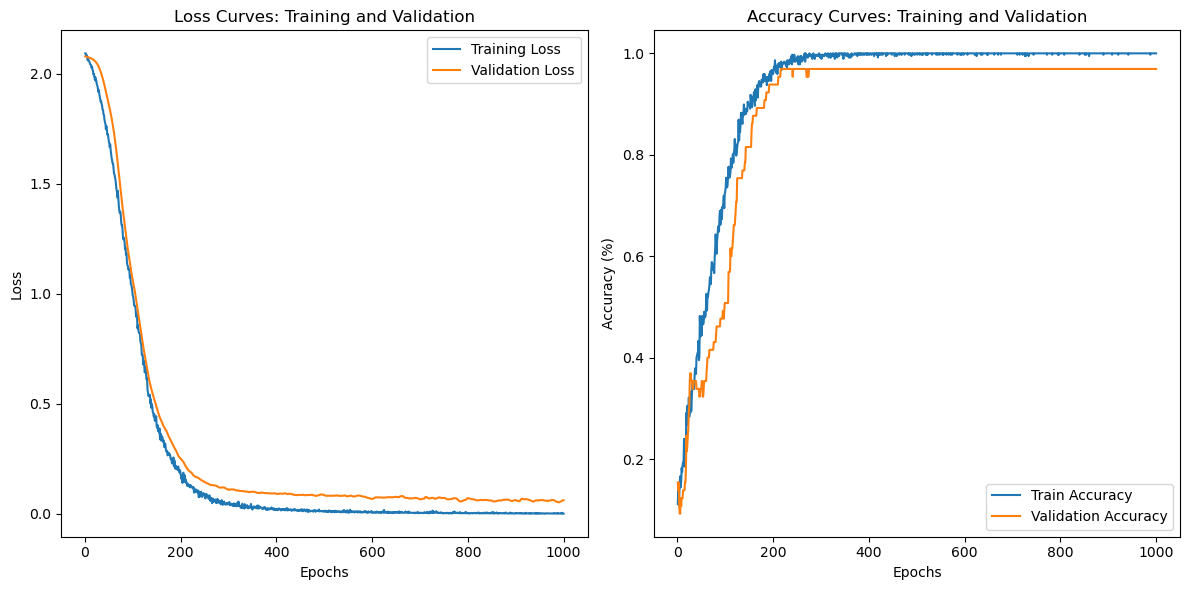

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000


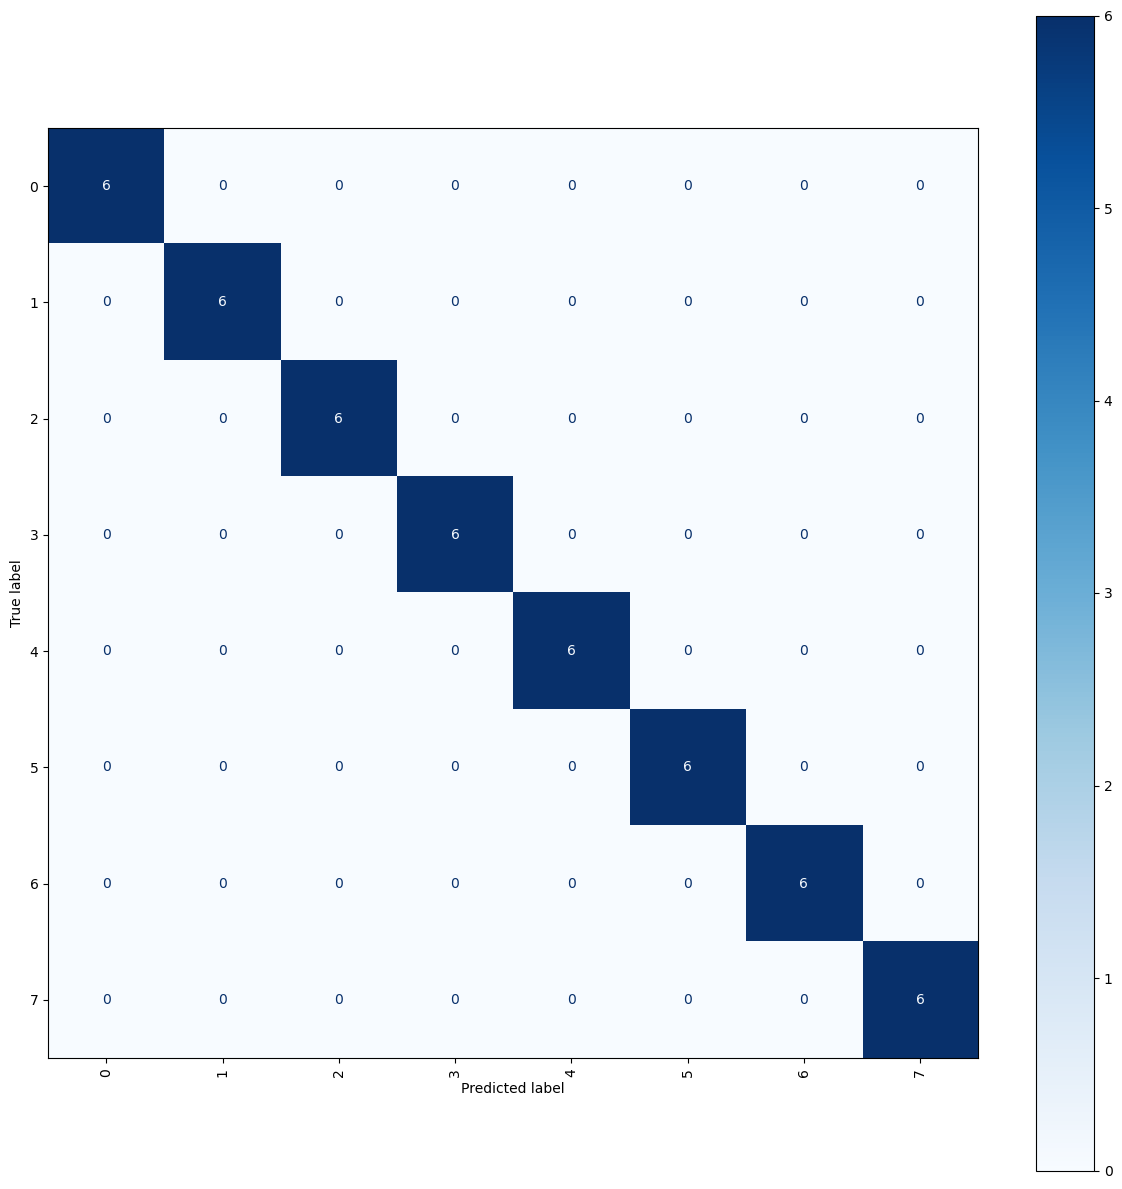

Test User 5 Finished: Accuracy=1.0000, Recall=1.0000, F1=1.0000
--------------------------------------------------
Processando Usuário 6
Train Users: [1, 2, 3, 4, 5, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0906, Train Accuracy: 0.1390, Val Loss: 2.0784, Val Accuracy: 0.1231
Epoch 2/1000: Train Loss: 2.0766, Train Accuracy: 0.1390, Val Loss: 2.0783, Val Accuracy: 0.1692
Epoch 3/1000: Train Loss: 2.0890, Train Accuracy: 0.1226, Val Loss: 2.0783, Val Accuracy: 0.1385
Epoch 4/1000: Train Loss: 2.0763, Train Accuracy: 0.1635, Val Loss: 2.0782, Val Accuracy: 0.1385
Epoch 5/1000: Train Loss: 2.0647, Train Accuracy: 0.1553, Val Loss: 2.0781, Val Accuracy: 0.1538
Epoch 6/1000: Train Loss: 2.0677, Train Accuracy: 0.1526, Val Loss: 2.0779, Val Accuracy: 0.1538
Epoch 7/1000: Train Loss: 2.0568, Train Accuracy: 0.1635, Val Loss: 2.0777, Val Accuracy: 0.1385
Epoch 8/1000: Train Loss: 2.0587, Train Accuracy: 0.1471, Val Loss: 2.0774, Val Accuracy: 0.1385
Epoch 9/1000: Train Loss: 2.0525, Train Accuracy: 0.1935, Val Loss: 2.0771, Val Accuracy: 0.1538
Epoch 10/1000: Train Loss: 2.0545, Train Accuracy: 0.1744, Val Loss: 2.0767, Val Accuracy: 0.1538
Epoch 11/1000: Train Loss: 2.

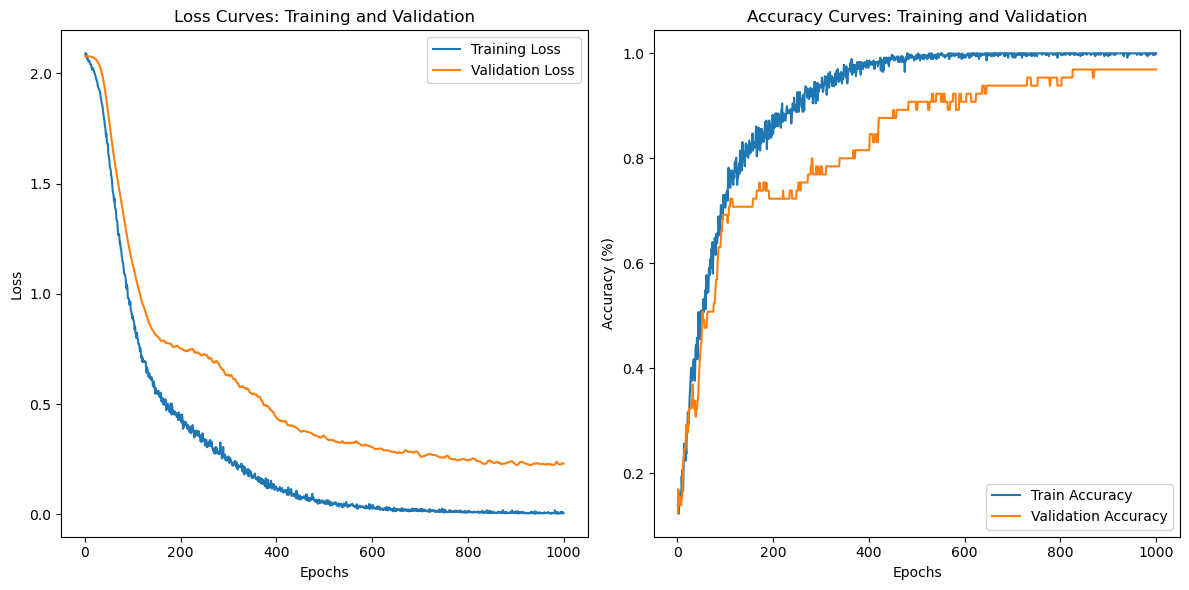

Test set Accuracy: 0.9792
Recall: 0.9792
F1 Score: 0.9790


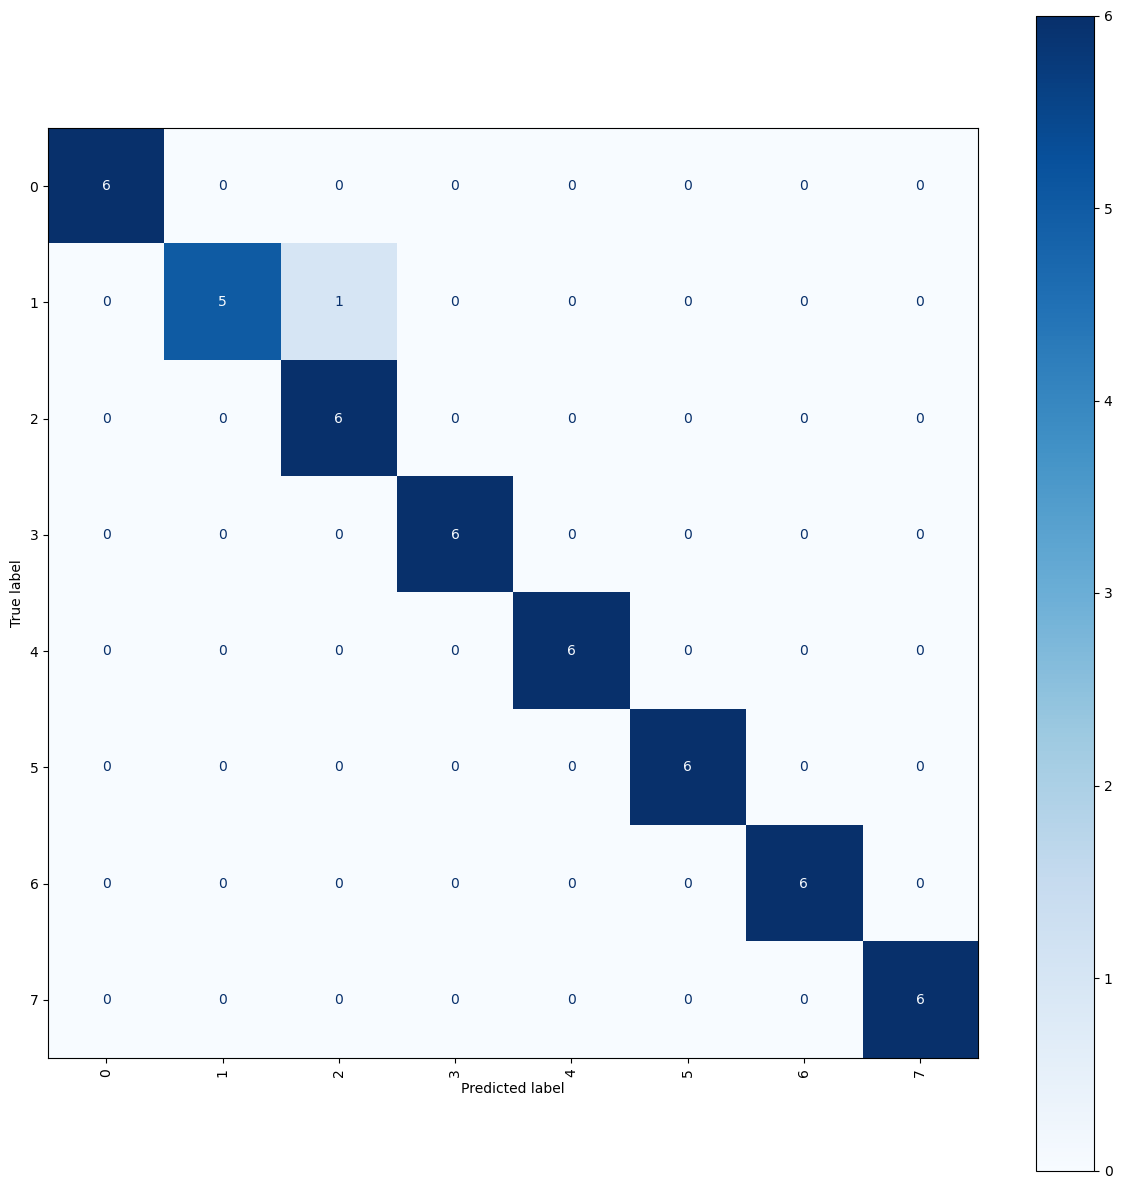

Test User 6 Finished: Accuracy=0.9792, Recall=0.9792, F1=0.9790
--------------------------------------------------
Processando Usuário 7
Train Users: [1, 2, 3, 4, 5, 6, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0967, Train Accuracy: 0.1580, Val Loss: 2.0782, Val Accuracy: 0.1692
Epoch 2/1000: Train Loss: 2.0813, Train Accuracy: 0.1444, Val Loss: 2.0782, Val Accuracy: 0.1077
Epoch 3/1000: Train Loss: 2.0898, Train Accuracy: 0.1580, Val Loss: 2.0781, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.0723, Train Accuracy: 0.1390, Val Loss: 2.0780, Val Accuracy: 0.1385
Epoch 5/1000: Train Loss: 2.0710, Train Accuracy: 0.1635, Val Loss: 2.0779, Val Accuracy: 0.1231
Epoch 6/1000: Train Loss: 2.0684, Train Accuracy: 0.1499, Val Loss: 2.0778, Val Accuracy: 0.1231
Epoch 7/1000: Train Loss: 2.0658, Train Accuracy: 0.1580, Val Loss: 2.0776, Val Accuracy: 0.1231
Epoch 8/1000: Train Loss: 2.0566, Train Accuracy: 0.1989, Val Loss: 2.0775, Val Accuracy: 0.1231
Epoch 9/1000: Train Loss: 2.0562, Train Accuracy: 0.1717, Val Loss: 2.0772, Val Accuracy: 0.1231
Epoch 10/1000: Train Loss: 2.0447, Train Accuracy: 0.1798, Val Loss: 2.0770, Val Accuracy: 0.1231
Epoch 11/1000: Train Loss: 2.

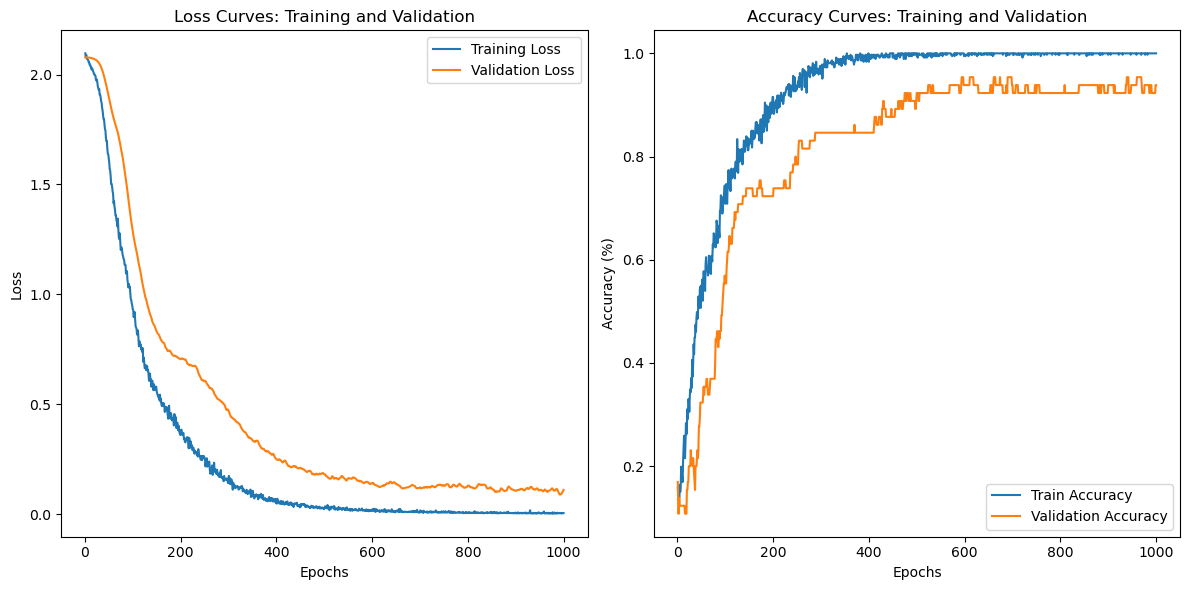

Test set Accuracy: 0.9583
Recall: 0.9583
F1 Score: 0.9582


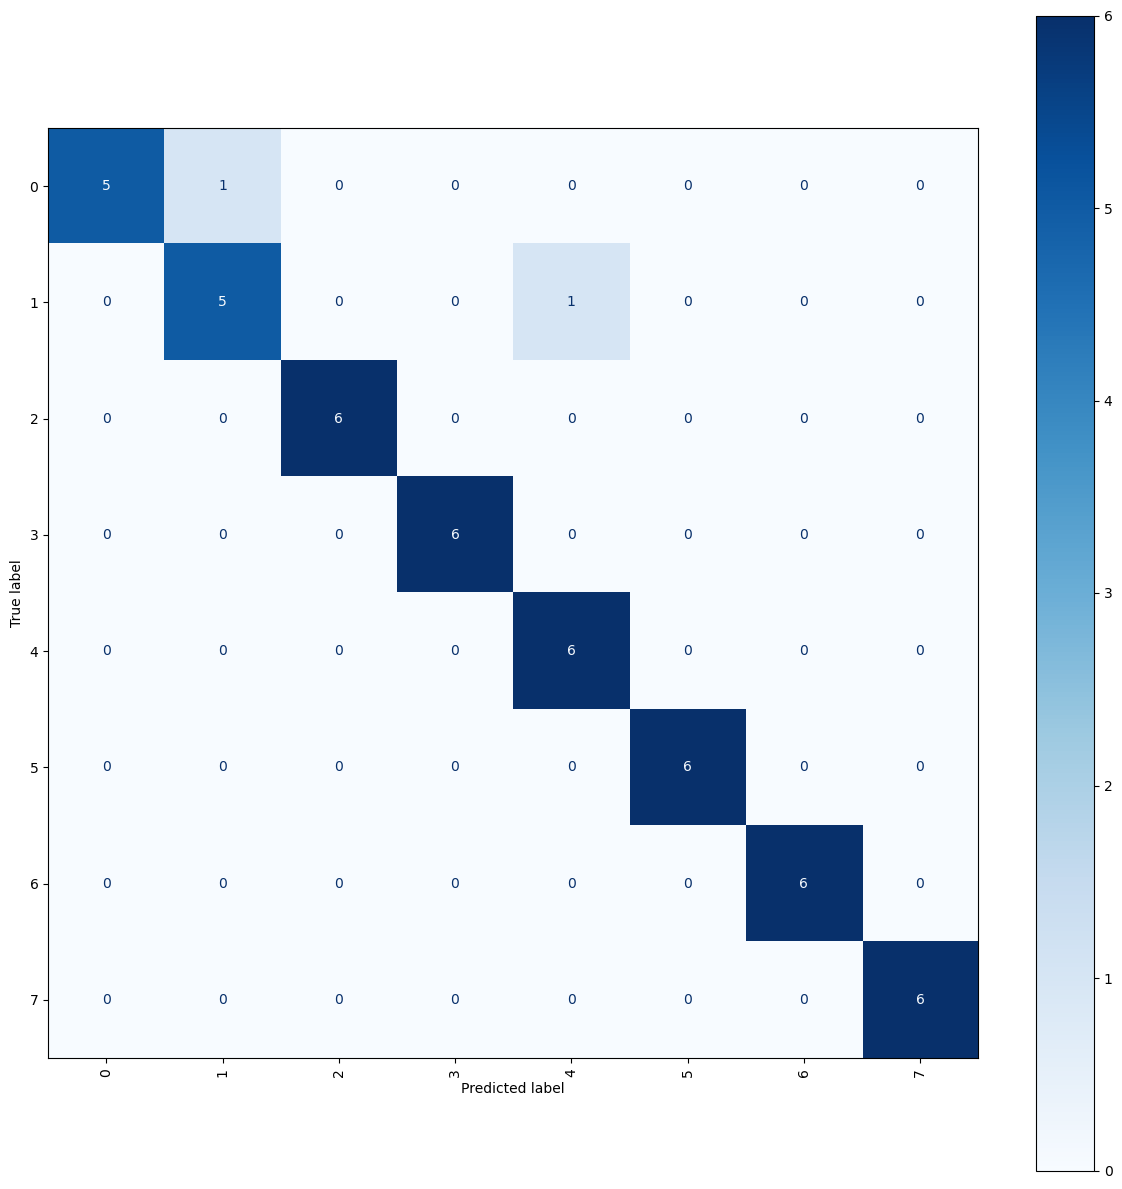

Test User 7 Finished: Accuracy=0.9583, Recall=0.9583, F1=0.9582
--------------------------------------------------
Processando Usuário 8
Train Users: [1, 2, 3, 4, 5, 6, 7, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0908, Train Accuracy: 0.1390, Val Loss: 2.0790, Val Accuracy: 0.0615
Epoch 2/1000: Train Loss: 2.0805, Train Accuracy: 0.1253, Val Loss: 2.0788, Val Accuracy: 0.0769
Epoch 3/1000: Train Loss: 2.0772, Train Accuracy: 0.1335, Val Loss: 2.0786, Val Accuracy: 0.0769
Epoch 4/1000: Train Loss: 2.0827, Train Accuracy: 0.1281, Val Loss: 2.0782, Val Accuracy: 0.1077
Epoch 5/1000: Train Loss: 2.0670, Train Accuracy: 0.1744, Val Loss: 2.0778, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.0661, Train Accuracy: 0.1471, Val Loss: 2.0774, Val Accuracy: 0.1538
Epoch 7/1000: Train Loss: 2.0770, Train Accuracy: 0.1553, Val Loss: 2.0768, Val Accuracy: 0.1538
Epoch 8/1000: Train Loss: 2.0559, Train Accuracy: 0.1689, Val Loss: 2.0763, Val Accuracy: 0.1538
Epoch 9/1000: Train Loss: 2.0580, Train Accuracy: 0.1798, Val Loss: 2.0758, Val Accuracy: 0.1538
Epoch 10/1000: Train Loss: 2.0543, Train Accuracy: 0.1798, Val Loss: 2.0751, Val Accuracy: 0.1538
Epoch 11/1000: Train Loss: 2.

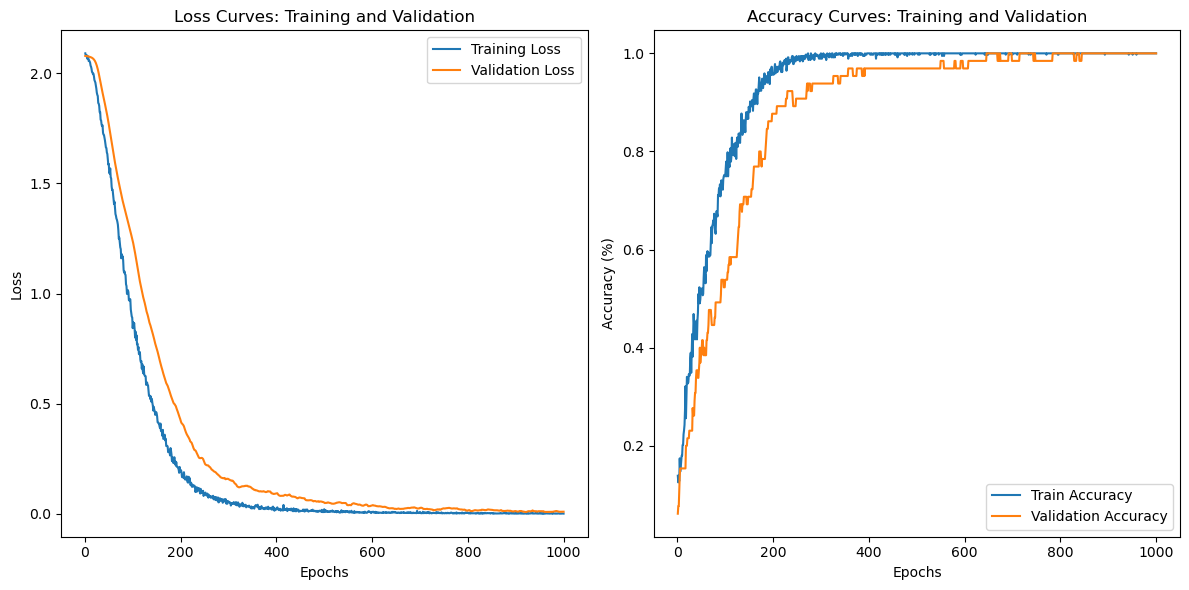

Test set Accuracy: 0.9167
Recall: 0.9167
F1 Score: 0.9177


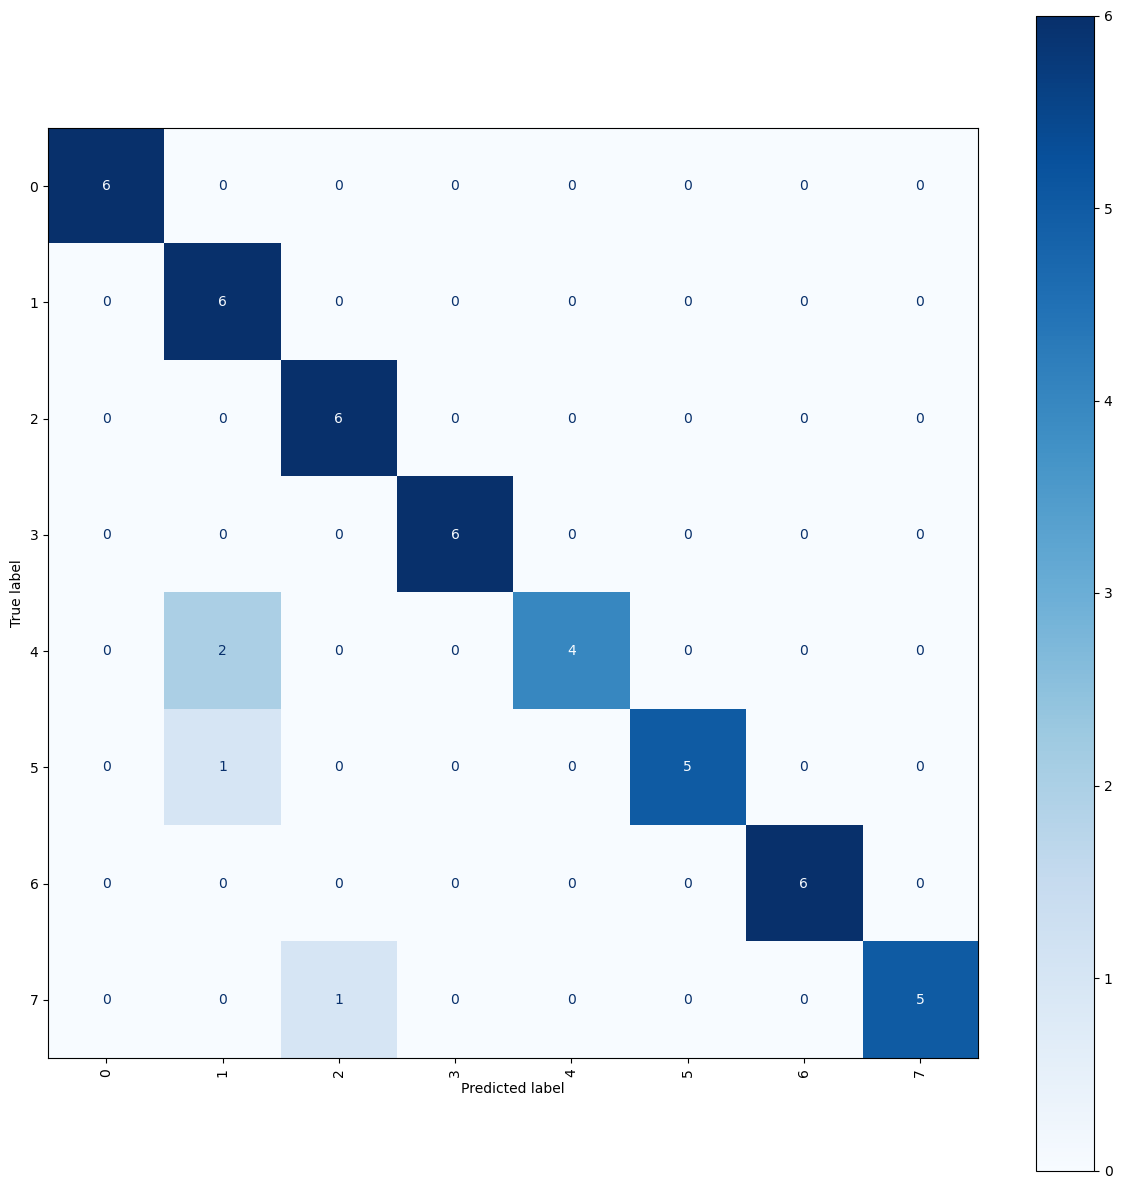

Test User 8 Finished: Accuracy=0.9167, Recall=0.9167, F1=0.9177
--------------------------------------------------
Processando Usuário 9
Train Users: [1, 2, 3, 4, 5, 6, 7, 8, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0761, Train Accuracy: 0.1499, Val Loss: 2.0810, Val Accuracy: 0.1538
Epoch 2/1000: Train Loss: 2.0783, Train Accuracy: 0.1417, Val Loss: 2.0815, Val Accuracy: 0.1077
Epoch 3/1000: Train Loss: 2.0686, Train Accuracy: 0.1471, Val Loss: 2.0820, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.0623, Train Accuracy: 0.1635, Val Loss: 2.0825, Val Accuracy: 0.1077
Epoch 5/1000: Train Loss: 2.0596, Train Accuracy: 0.1580, Val Loss: 2.0830, Val Accuracy: 0.1077
Epoch 6/1000: Train Loss: 2.0535, Train Accuracy: 0.2044, Val Loss: 2.0834, Val Accuracy: 0.1077
Epoch 7/1000: Train Loss: 2.0489, Train Accuracy: 0.1798, Val Loss: 2.0838, Val Accuracy: 0.1231
Epoch 8/1000: Train Loss: 2.0401, Train Accuracy: 0.1935, Val Loss: 2.0842, Val Accuracy: 0.1231
Epoch 9/1000: Train Loss: 2.0421, Train Accuracy: 0.2016, Val Loss: 2.0845, Val Accuracy: 0.1231
Epoch 10/1000: Train Loss: 2.0348, Train Accuracy: 0.2098, Val Loss: 2.0848, Val Accuracy: 0.1231
Epoch 11/1000: Train Loss: 2.

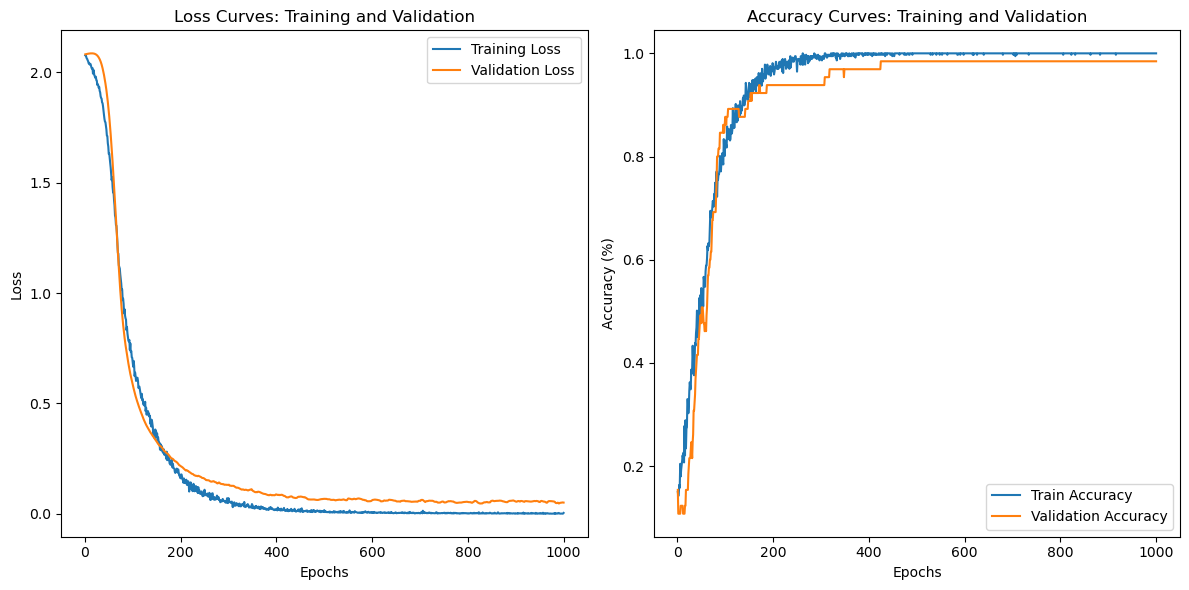

Test set Accuracy: 0.8125
Recall: 0.8125
F1 Score: 0.7914


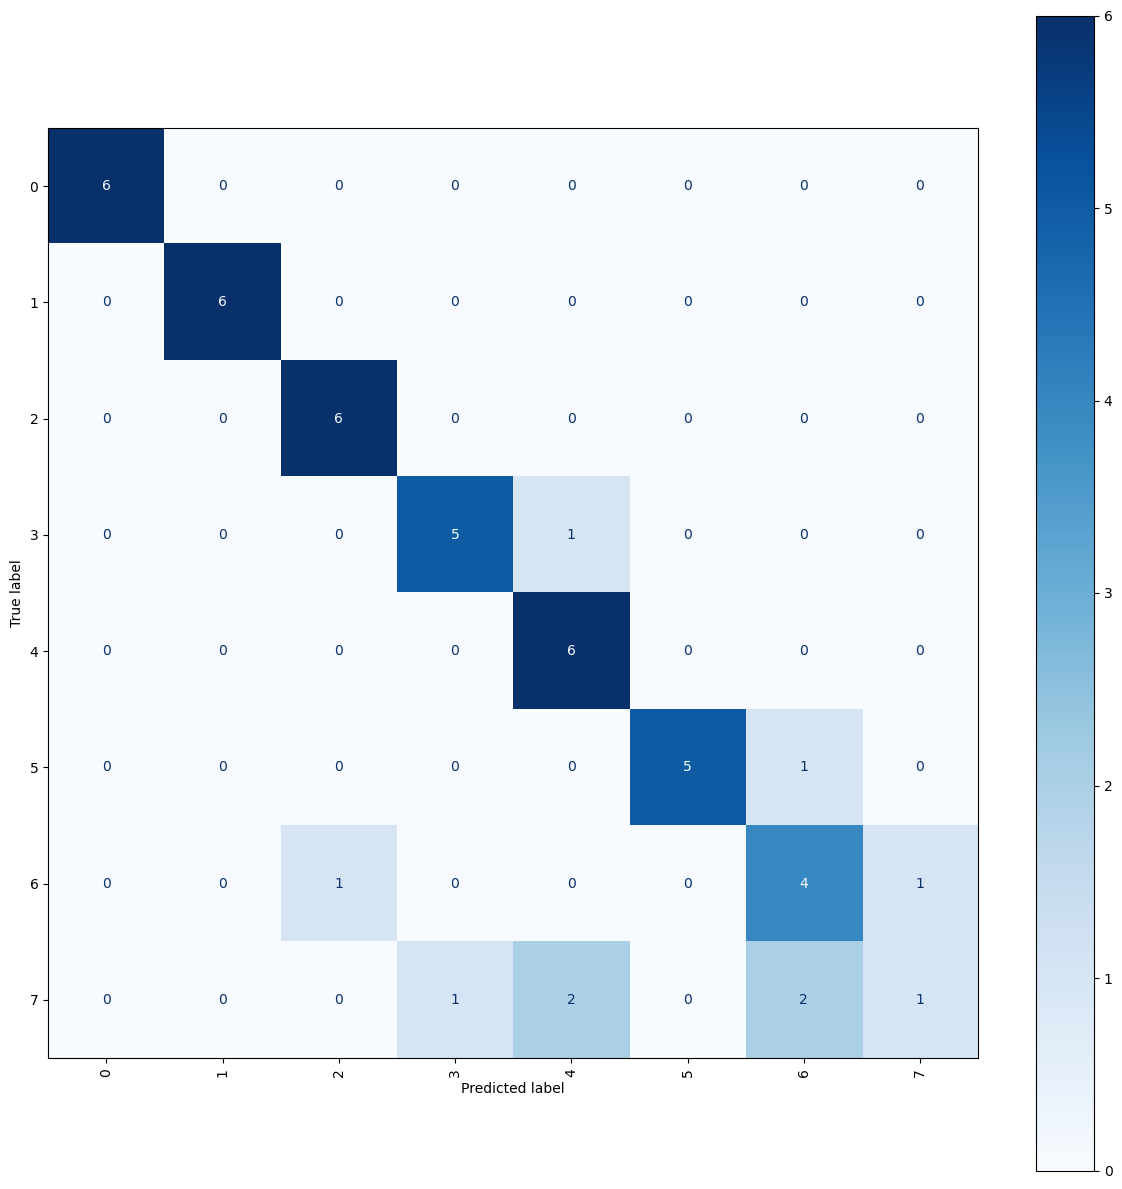

Test User 9 Finished: Accuracy=0.8125, Recall=0.8125, F1=0.7914
--------------------------------------------------
Processando Usuário 10
Train Users: [1, 2, 3, 4, 5, 6, 7, 8, 9]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
theta: 0
y shape: (1000, 10)
Y shape: (1000, 10)
5
Generating 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.0888, Train Accuracy: 0.1335, Val Loss: 2.0812, Val Accuracy: 0.1077
Epoch 2/1000: Train Loss: 2.0749, Train Accuracy: 0.1390, Val Loss: 2.0817, Val Accuracy: 0.1231
Epoch 3/1000: Train Loss: 2.0637, Train Accuracy: 0.1526, Val Loss: 2.0822, Val Accuracy: 0.1385
Epoch 4/1000: Train Loss: 2.0723, Train Accuracy: 0.1281, Val Loss: 2.0827, Val Accuracy: 0.1538
Epoch 5/1000: Train Loss: 2.0574, Train Accuracy: 0.1662, Val Loss: 2.0833, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.0571, Train Accuracy: 0.1580, Val Loss: 2.0838, Val Accuracy: 0.1538
Epoch 7/1000: Train Loss: 2.0443, Train Accuracy: 0.1662, Val Loss: 2.0843, Val Accuracy: 0.1538
Epoch 8/1000: Train Loss: 2.0399, Train Accuracy: 0.1907, Val Loss: 2.0848, Val Accuracy: 0.1538
Epoch 9/1000: Train Loss: 2.0495, Train Accuracy: 0.1635, Val Loss: 2.0853, Val Accuracy: 0.1692
Epoch 10/1000: Train Loss: 2.0365, Train Accuracy: 0.2153, Val Loss: 2.0858, Val Accuracy: 0.1692
Epoch 11/1000: Train Loss: 2.

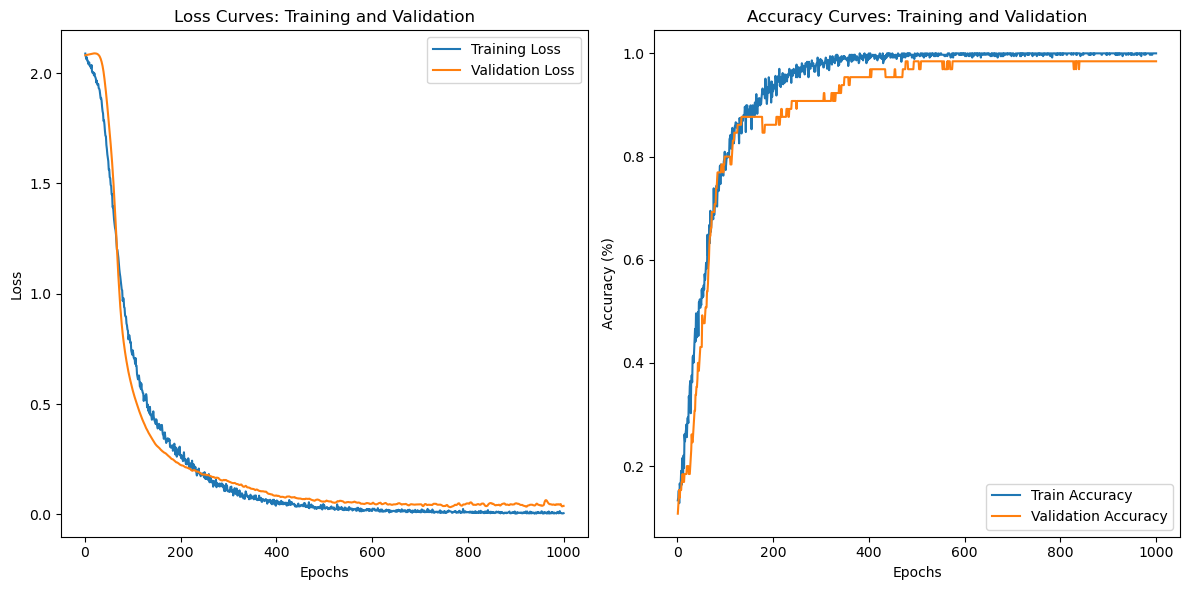

Test set Accuracy: 0.8958
Recall: 0.8958
F1 Score: 0.9000


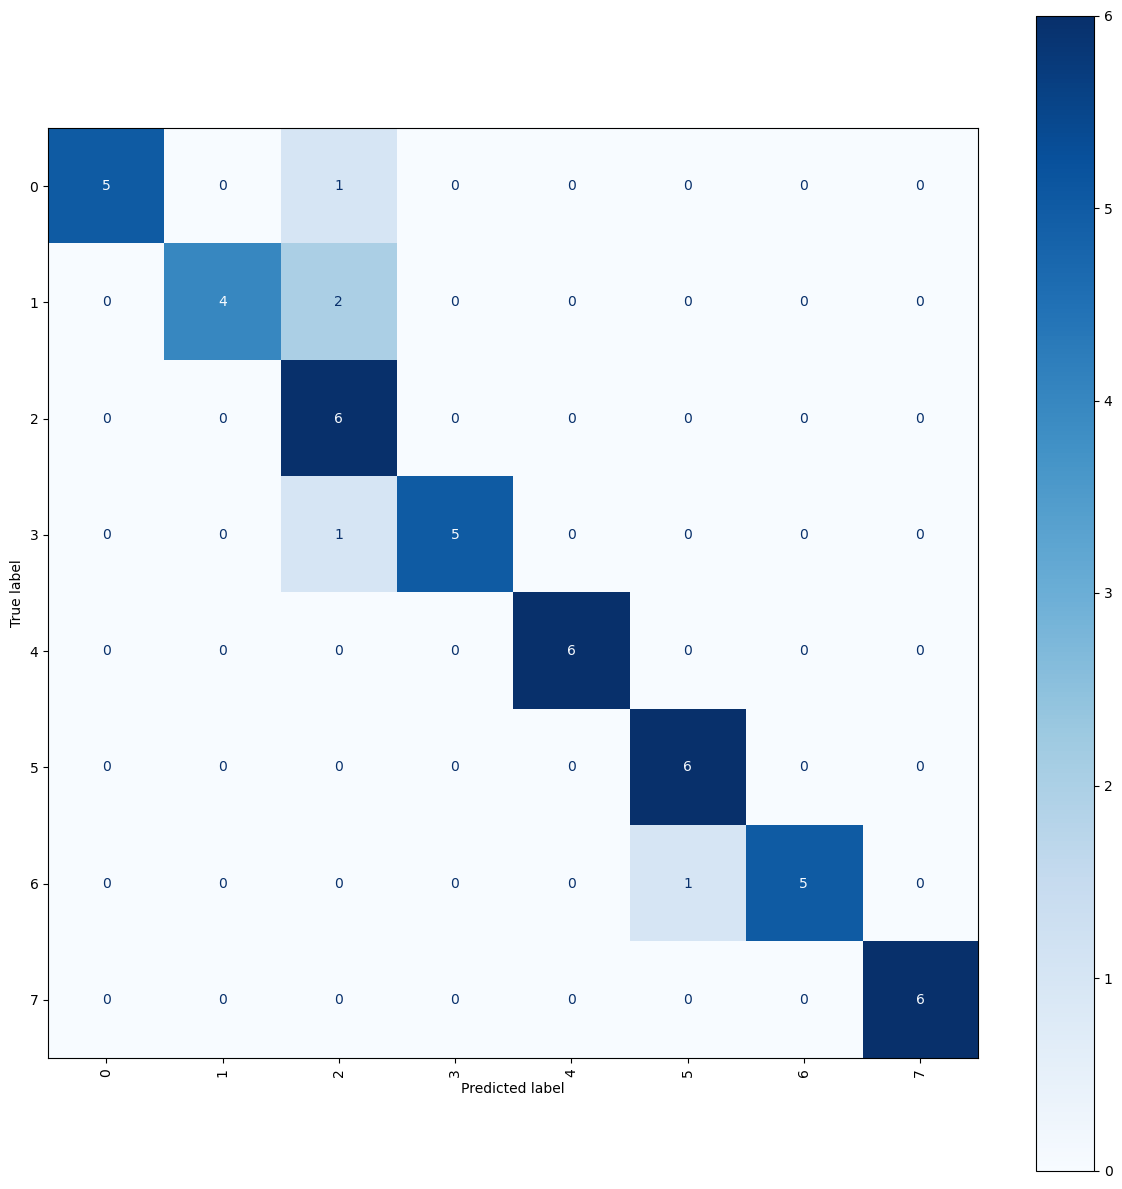

Test User 10 Finished: Accuracy=0.8958, Recall=0.8958, F1=0.9000
--------------------------------------------------


In [13]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

# Cross-Subject EEGNet Training (single window per trial, no window separation)
metricas_usuarios = []
exp_dir.mkdir(parents=True, exist_ok=True)

# Prepare cross-subject splits
for test_user_idx, test_user in enumerate(users):
    print(f"Processando Usuário {test_user}")
    train_users = [u for u in users if u != test_user]
    print(f"Train Users: {train_users}")

    # Concatenate training data from all train_users
    train_data = np.concatenate(
        [all_data[users.index(u)] for u in train_users], axis=-1
    )  # shape: (channels, samples, freqs, trials)
    test_data = all_data[test_user_idx]

    num_canais, _, num_freqs, num_trials_train = train_data.shape
    num_trials_test = test_data.shape[-1]

    # Prepare reference matrices for all frequencies (no window separation)
    Y_train = np.zeros(
        (tamanho_da_janela, num_harmonica * 2, len(indices))
    )
    Y_test = np.zeros(
        (tamanho_da_janela, num_harmonica * 2, len(indices))
    )
    for k in indices:
        print(k)
        print(
            f"Generating reference for frequency index {k}, frequency {frequencias[k]} Hz"
        )
        y_train = matriz_referencia(
            num_harmonica,
            inform_fase,
            1,
            frequencias[k],
            fases,
            tamanho_da_janela,
        )
        Y_train[:, :, k] = y_train
        y_test = matriz_referencia(
            num_harmonica,
            inform_fase,
            1,
            frequencias[k],
            fases,
            tamanho_da_janela,
        )
        Y_test[:, :, k] = y_test

    # Construir tensores
    rotulos_treinamento = []
    tensor_treinamento = np.zeros(
        [len(indices) * num_trials_train, len(indices), tamanho_da_janela]
    )
    rotulos_teste = []
    tensor_teste = np.zeros(
        [len(indices) * num_trials_test, len(indices), tamanho_da_janela]
    )
    for k in range(len(indices)):
        for session in range(num_trials_train):
            eeg_matrix_train = train_data[
                occipital_electrodes, :tamanho_da_janela, indices[k], session
            ]
            eeg_matrix_train = np.transpose(eeg_matrix_train)
            rotulos_treinamento.append(k)
            for freq in range(len(indices)):
                Wx, Wy, corr = CCA_otimizacao(eeg_matrix_train, Y_train[:, :, freq])
                tensor_treinamento[k * num_trials_train + session, freq, :] = np.dot(Wx, eeg_matrix_train.T)

        for session in range(num_trials_test):
            eeg_matrix_test = test_data[
                occipital_electrodes, :tamanho_da_janela, indices[k], session
            ]
            eeg_matrix_test = np.transpose(eeg_matrix_test)
            rotulos_teste.append(k)
            for freq in range(len(indices)):
                Wx, Wy, corr = CCA_otimizacao(eeg_matrix_test, Y_test[:, :, freq])
                tensor_teste[k * num_trials_test + session, freq, :] = np.dot(Wx, eeg_matrix_test.T)

    # --------------------------------------------------------------------------------------
    X_treino = torch.tensor(tensor_treinamento, dtype=torch.float32).to(device)
    X_teste = torch.tensor(tensor_teste, dtype=torch.float32).to(device)
    Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
    Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)
    print("X_train:", X_treino.shape)
    print("X_test:", X_teste.shape)
    print("Y_train:", Y_treino.shape)
    print("Y_test:", Y_teste.shape)

    # Model setup
    model = EEGNet(
        n_chans=8,
        n_outputs=8,
        n_times=tamanho_da_janela,
        kernel_length=(tamanho_da_janela // 2),
    )

    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    dataset = TensorDataset(X_treino, Y_treino)
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed)
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(
        TensorDataset(X_teste, Y_teste), batch_size=10, shuffle=False
    )

    # Train
    best_model = train(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs,
        device=device,
        save_path=exp_dir.joinpath(f"best_model_user_{test_user}.pth"),
    )

    # Evaluate
    accuracy, recall, f1, cm = evaluate(best_model, test_loader)

    metricas_usuarios.append(
        {
            "usuario": test_user,
            "acuracia": accuracy,
            "recall": recall,
            "f1-score": f1,
            "confusion_matrix": cm,
        }
    )
    print(
        f"Test User {test_user} Finished: Accuracy={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
    )

    # Salvar as métricas de cada usuário
    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(exp_dir.joinpath("metricas.csv"), index=False)

    print("-" * 50)